# Predicting Citation Count by Keywords using Regression Models

Models adapted from https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a 

Start Spark Session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf


In [2]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','12g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [3]:
paps = spark.read.json("../data/processed/dummy.json/")

The data used in this model was 2019 data, gathered in the same manner as the AL_read_papers notebook.
I used wget "https://inspirehep.net/api/literature?sort=mostrecent&size=1000&page=1&q=date%202019&subject=Phenomenology-HEP" -O papers_2019.json to get these papers, and extracted keywords using aleksei's notebook.

**remove NAN values so we can fit a model with no errors**

In [4]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

3000
2931
1852


## Data Transformation

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def column_to_list(data):
    return np.array([r[0] for r in data.collect()])

As you can see, some transformation is requred to "number_of_paged" and "num_refs" fields

In [7]:
data = papersWIDs_woNA_woNone

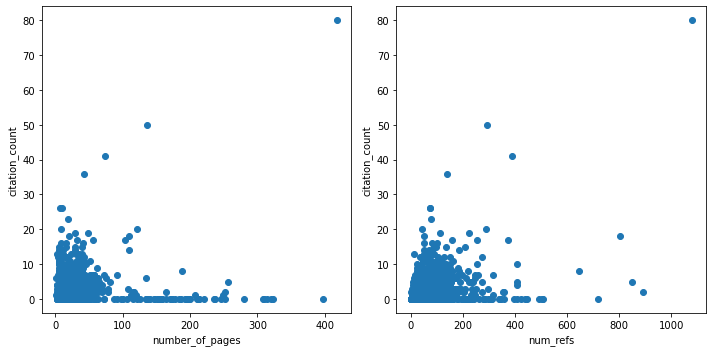

In [8]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
for (ax, t) in zip(axes, ["number_of_pages", "num_refs"]):
    ax.scatter(column_to_list(data.select(t)), column_to_list(data.select("citation_count")))
    ax.set_xlabel(t)
    ax.set_ylabel("citation_count")
plt.tight_layout()
plt.show()

Simple log will be used

In [9]:
from pyspark.sql.functions import log

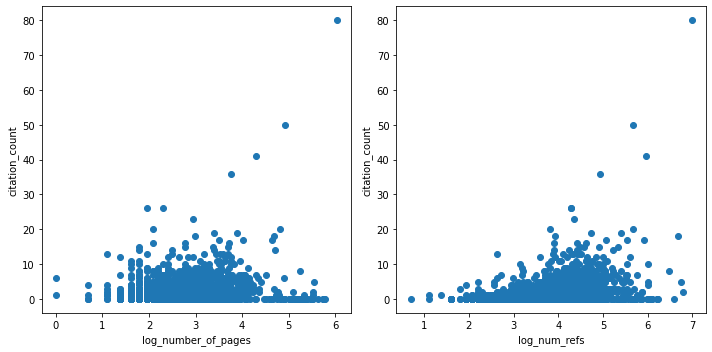

In [10]:
data = data.withColumn("log_number_of_pages", log(col("number_of_pages")))
data = data.withColumn("log_num_refs", log(col("num_refs")))
data = data.dropna()
fig, axes = plt.subplots(1,2, figsize = (10,5))
for (ax, t) in zip(axes, ["log_number_of_pages", "log_num_refs"]):
    ax.scatter(column_to_list(data.select(t)), column_to_list(data.select("citation_count")))
    ax.set_xlabel(t)
    ax.set_ylabel("citation_count")
plt.tight_layout()
plt.show()

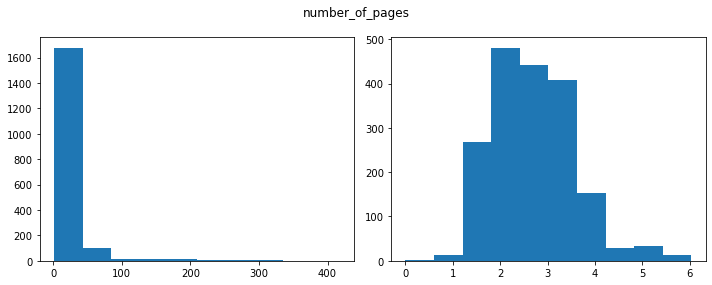

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))
axes[0].hist(column_to_list(data.select("number_of_pages")))
axes[1].hist(column_to_list(data.select("log_number_of_pages")))
plt.suptitle("number_of_pages")
plt.tight_layout()

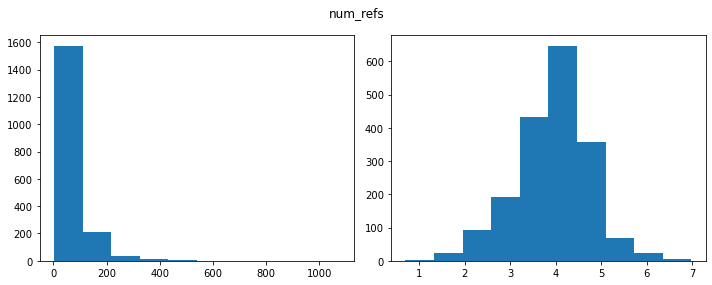

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))
axes[0].hist(column_to_list(data.select("num_refs")))
axes[1].hist(column_to_list(data.select("log_num_refs")))
plt.suptitle("num_refs")
plt.tight_layout()

# Create features column so that we can fit a regression model. 
Title is not included since it is the only non-numeric column.

What this means is that, the models we will be constructing will attempt to predict Citation Count based off of the keywords. The real world implications of this would be knowing that papers on certain topics are cited more, and allow authors to write more influential papers on well documented topics. 

In [11]:
from pyspark.ml.feature import VectorAssembler

numericCols = [c[0] for c in data.dtypes if (c[1] == 'bigint' or c[1] == 'double') and not c[0] in ['citation_count', "number_of_pages", "num_refs"]]
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
df = assembler.transform(data)
#df.show()

In [12]:
from pyspark.ml.feature import StringIndexer

label_stringIdx = StringIndexer(inputCol = 'citation_count', outputCol = 'labelIndex')
df = label_stringIdx.fit(df).transform(df)
#df.show()

# Split Data into Training and Testing Set
70% of papers will be used for training, and it's performance will be evaluated on the training set. 
Future work could include not splitting the data, but using 20xx data for testing, and 20xx+1 data as testing.

In [13]:
from pyspark.sql.functions import log, sqrt, lit, exp

In [14]:
df2 = df.withColumn("cit", (lit(-30)+col("citation_count"))**2)
train, test = df2.randomSplit([0.7, 0.3], seed = 2018)

In [15]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='cit', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [15.355485091373554,22.048676581280958,0.0,-64.74237384468935,-11.656305557257856,-8.181719185907099,-31.323807258528678,-21.6592178959305,14.092367779466782,-17.60783680227719,2.8380911855994095,1.1000054023459562,18.67840357433003,-3.0098532167671013,-9.318322620271916,37.21843637534115,19.052521084584157,17.8988944160754,6.912030269834423,13.318253028650775,-12.78472911189629,1.527658528821143e-09,20.549006537200594,-74.83537294552666]
Intercept: 1010.4609952650997


In [16]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 135.235723
r2: 0.171785


In [167]:
# train.describe().show()

In [168]:
lr_predictions = lr_model.transform(test)
#lr_predictions.select("prediction","cit","features").show(20)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cit",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.0744232


In [169]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 135.984


In [170]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5000000000000018, 0.4746077524552129, 0.4048110267434249, 0.39954605659631814, 0.3952751236083692, 0.39466109124771837, 0.39401424514651345, 0.3937774683055719, 0.3936552464868897, 0.39364592926866493, 0.39364237036546484]
+------------------+
|         residuals|
+------------------+
|  93.2707423731589|
|-39.96058038295075|
| 64.85739265311418|
|103.63542846555299|
| 80.79138065674692|
| 89.37697967072404|
|138.18572909508748|
| 43.43652249042452|
| 97.17818867706524|
|  8.78984610574878|
|23.563835457587174|
| 52.21073998432803|
|25.175852950610306|
| 89.04370673175583|
|121.54376780298344|
| 44.68463882109063|
| 95.85525716064694|
|105.44191355500038|
|135.05643954393395|
| 75.51258875951885|
+------------------+
only showing top 20 rows



In [171]:
import pandas as pd

In [172]:
pdf = pd.DataFrame({
    "residuals":column_to_list( trainingSummary.residuals),
    "actual":column_to_list( trainingSummary.predictions.select("cit")),
    "prediction": column_to_list( trainingSummary.predictions.select("prediction"))
})

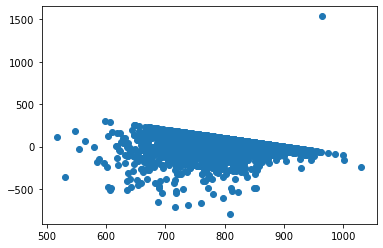

In [173]:
plt.scatter(pdf.prediction, pdf.residuals)


In [24]:
predictions = lr_model.transform(test)
predictions.select("prediction","citation_count","features").show(20)

+------------------+--------------+--------------------+
|        prediction|citation_count|            features|
+------------------+--------------+--------------------+
|0.8509941167202064|             0|(23,[14,15,21],[-...|
| 1.107702857559625|             0|(23,[14,15,18],[1...|
|1.1993845507165604|             0|(23,[14,15,16,19]...|
|1.1993845507165604|             0|(23,[14,15,16,21]...|
|1.2360572279793345|             0|(23,[14,15,16],[2...|
|1.2727299052421084|             0|(23,[14,15,18],[2...|
|1.3460752597676566|             0|(23,[14,15,16,22]...|
|1.5294386460815272|             0|(23,[14,15,16],[3...|
|1.5294386460815272|             0|(23,[14,15,18],[3...|
|1.5844476619756884|             0|(23,[14,15,21],[3...|
|1.6394566778698496|             0|(23,[14,15,21],[4...|
|1.6944656937640106|             0|(23,[14,15,17],[4...|
| 1.804483725552333|             0|(23,[14,15,21,22]...|
|  1.82282006418372|             0|(23,[14,15,18],[5...|
|2.2078831754428476|           

## Evaluation of Linear Regression
This model performed with an RMSE of ~14 on the testing data. This isn't the most accurate model ever, however it does do an okay job at predicting citations.

In [177]:
test_result = lr_model.transform(test)
test_result.summary()

summary,ATLAS,BELLE,Beyond_Standard_Model,CERN_LHC_Coll,CMS,CP__violation,GeV,LHC-B,Monte_Carlo,None,TeV,anomaly,axion-like_particles,background,baryon,black_hole__primordial,bound_state,branching_ratio,charm,chiral,citation_count,correlation,cosmic_background_radiation,cosmological_model,cosmological_model__parameter_space,critical_phenomena,dark_matter,dark_matter__density,dark_matter__direct_detection,dark_matter__mass,dark_matter__relic_density,data_analysis_method,effective_field_theory,electron,electroweak_interaction,energy__density,energy__high,energy__low,equation_of_state,excited_state,experimental_results,field_theory__scalar,flavor,formation,gauge_field_theory,gluon,gravitation,gravitational_radiation,hadron,heavy_ion__scattering,heavy_quark,higher-order__1,higher-order__2,id,inflation,interpretation_of_experiments__CERN_LHC_Coll,kinematics,lattice,lattice_field_theory,lepton,mass_spectrum,mediation,meson,mixing,muon__magnetic_moment,neural_network,neutrino__mass,neutrino__oscillation,neutrino__sterile,new_physics,nonperturbative,nucleon,nucleus,num_refs,number_of_pages,numerical_calculations,numerical_calculations__Monte_Carlo,p_p__scattering,parton__distribution_function,perturbation_theory,phase_space,photon,potential__chemical,quantum_chromodynamics,quantum_chromodynamics__correction,quantum_chromodynamics__perturbation_theory,quark,quark__mass,quark_gluon__plasma,rapidity,resummation,scaling,scattering,scattering_amplitude,sensitivity,signature,stability,structure,supersymmetry,suppression,temperature,thermal,title,transverse_momentum__momentum_spectrum,tree_approximation,unitarity,log_number_of_pages,log_num_refs,labelIndex,cit,prediction
count,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744,744
mean,0.021505376344086023,0.025537634408602152,0.03494623655913978,0.0913978494623656,0.0228494623655914,0.02956989247311828,0.041666666666666664,0.028225806451612902,0.0228494623655914,0.0,0.02956989247311828,0.03763440860215054,0.020161290322580645,0.038978494623655914,0.012096774193548387,0.013440860215053764,0.028225806451612902,0.026881720430107527,0.020161290322580645,0.020161290322580645,2.088709677419355,0.024193548387096774,0.01747311827956989,0.036290322580645164,0.024193548387096774,0.033602150537634407,0.036290322580645164,0.021505376344086023,0.01881720430107527,0.036290322580645164,0.03225806451612903,0.025537634408602152,0.051075268817204304,0.025537634408602152,0.02956989247311828,0.028225806451612902,0.030913978494623656,0.0228494623655914,0.01747311827956989,0.013440860215053764,0.01747311827956989,0.038978494623655914,0.030913978494623656,0.020161290322580645,0.0228494623655914,0.028225806451612902,0.020161290322580645,0.0228494623655914,0.01881720430107527,0.05510752688172043,0.013440860215053764,0.043010752688172046,0.0228494623655914,8.43984213965457E9,0.028225806451612902,0.04032258064516129,0.0456989247311828,0.043010752688172046,0.04032258064516129,0.024193548387096774,0.01747311827956989,0.01881720430107527,0.01478494623655914,0.041666666666666664,0.024193548387096774,0.021505376344086023,0.038978494623655914,0.026881720430107527,0.0228494623655914,0.0913978494623656,0.030913978494623656,0.01747311827956989,0.030913978494623656,69.46370967741936,22.350806451612904,0.09946236559139784,0.024193548387096774,0.04838709677419355,0.03494623655913978,0.025537634408602152,0.01747311827956989,0.025537634408602152,0.025537634408602152,0.0793010752688172,0.025537634408602152,0.028225806451612902,0.04973118279569892,0.024193548387096774,0.03225806451612903,0.01881720430107527,0.01881720430107527,0.0228494623655914,0.014

# Decision Tree Regression

In [16]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'citation_count')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="citation_count", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 15.0328


In [17]:
dt_model.featureImportances


SparseVector(23, {1: 0.003, 5: 0.2754, 6: 0.0074, 7: 0.0295, 9: 0.0029, 10: 0.0074, 13: 0.0148, 14: 0.497, 15: 0.0698, 18: 0.0341, 19: 0.02, 20: 0.0117, 21: 0.027})

This model performed with an RMSE of 15, which is roughly the same accuracy as the standard regression model.

# GBT Regression

In [18]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'citation_count', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'citation_count', 'features').sort('prediction').show(20)

+-------------------+--------------+--------------------+
|         prediction|citation_count|            features|
+-------------------+--------------+--------------------+
| -4.758025729493576|            19|(23,[1,13,14,15,1...|
|0.43929852742762365|             0|(23,[2,14,15],[1....|
| 0.8477842724012375|             1|(23,[13,14,15],[1...|
| 1.0574511190273665|             3|(23,[14,15,18,21]...|
| 1.4119738664636814|            10|(23,[2,14,15,17],...|
| 1.6797149286371216|             0|(23,[14,15,16],[7...|
| 1.6797149286371216|             1|(23,[14,15,16],[7...|
| 1.6797149286371216|             4|(23,[14,15,18],[8...|
| 2.0412499417114693|             0|(23,[12,13,14,15,...|
| 2.1118824056366816|             0|(23,[13,14,15],[1...|
|   2.11771230729489|             1|(23,[13,14,15],[1...|
|   2.11771230729489|             0|(23,[13,14,15],[1...|
|   2.11771230729489|             1|(23,[13,14,15],[1...|
| 2.1361174476605007|             2|(23,[14,15,16],[1...|
| 2.1361174476

In [19]:
gbt_evaluator = RegressionEvaluator(
    labelCol="citation_count", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 15.2337


This model also performed with an RMSE of ~15, which has roughly the same predictive power as the other models.